In [1]:
import os
import os.path as osp
import copy
import glob
import pickle
import numpy as np
import pandas as pd
import torch
from nilearn import plotting, image
from nilearn.datasets import fetch_atlas_aal
from group_lasso import GroupLasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import seaborn as sns
from mylib.sparse_modeling import sparsegrouplassocv
from mylib.config import CFG
from mylib.visualization import plot_cluster_AAL, cluster_separation
from net.braingnn import Network3layers
from mylib.utils import seed_worker

AttrDict({'n_epochs': 100, 'n_splits': 5, 'lr_init': '1e-3', 'weight_decay': '5e-3', 'patience': 10, 'ratio': 0.5, 'k': 7, 'lambda_p': 0.1, 'lambda_tpk': 0.1, 'batch_size': 32})
9.548576058451925 0.13605127850302107
2


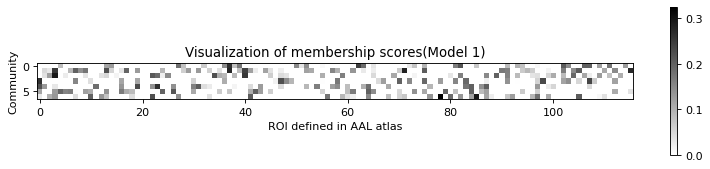

In [3]:
# 最良の精度のmodel1についてクラスタリングの結果を検証
res = "../log/model1"
k = 7
shrink = 0.2
result_path = osp.join(res, "results.pkl")
with open(result_path, 'rb') as p:
    l = pickle.load(p)
print(l["params"])
print(np.mean(l["mae"]), np.std(l["mae"]))
print(l["best_fold"])
model = Network3layers(indim = 116, ratio = 0.5, k = k, nclass = 1, R = 116)
w_path = osp.join(res, f"fold_{l['best_fold']}/model_weights.pth")
w = torch.load(w_path)
nn1_weight = model.state_dict(w)["module.n1.0.weight"].detach().cpu().numpy()
nn1_weight = np.array(nn1_weight)
nn1_weight_th = nn1_weight * np.where(
    nn1_weight > 0, 1, 0
)
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(nn1_weight_th, cmap="binary")
plt.colorbar(shrink=shrink)
plt.xlabel("ROI defined in AAL atlas")
plt.ylabel("Community")
plt.title(f"Visualization of membership scores(Model 1)")
plt.show()

# コサイン類似度の計算
- [参照](https://stackoverflow.com/questions/17627219/whats-the-fastest-way-in-python-to-calculate-cosine-similarity-given-sparse-mat)

[[1.         0.27261388 0.24609533 0.25951496 0.07061746 0.14452352
  0.13639362]
 [0.27261388 1.         0.30370596 0.25032685 0.161933   0.33866202
  0.22243635]
 [0.24609533 0.30370596 1.         0.10837686 0.21323916 0.15976621
  0.29296721]
 [0.25951496 0.25032685 0.10837686 1.         0.31068085 0.19192729
  0.16285016]
 [0.07061746 0.161933   0.21323916 0.31068085 1.         0.37616587
  0.26006341]
 [0.14452352 0.33866202 0.15976621 0.19192729 0.37616587 1.
  0.24615133]
 [0.13639362 0.22243635 0.29296721 0.16285016 0.26006341 0.24615133
  1.        ]]


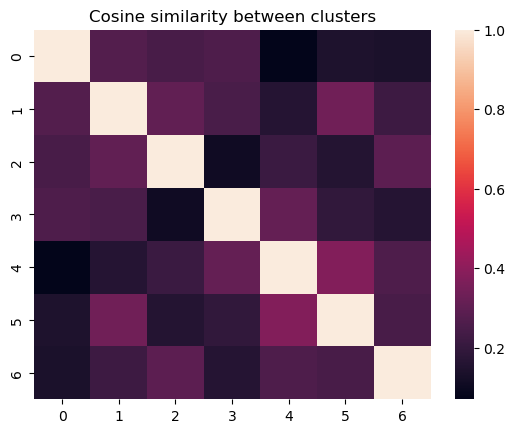

In [57]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
dist_out = 1-pairwise_distances(nn1_weight_th, metric="cosine")
print(dist_out)
plt.figure()
sns.heatmap(dist_out)
plt.title("Cosine similarity between clusters")
plt.show()

# t-SNEによる可視化

In [45]:
print(list(range(1,8)))

[1, 2, 3, 4, 5, 6, 7]


/opt/conda/envs/braingnn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/braingnn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-270.91327    234.50328  ]
 [  -0.9351555 -260.81763  ]
 [-356.266       40.184124 ]
 [ -89.776085   212.29286  ]
 [ -18.931963    64.175705 ]
 [  -6.5112724  -68.16813  ]
 [-341.44885    -91.36433  ]]


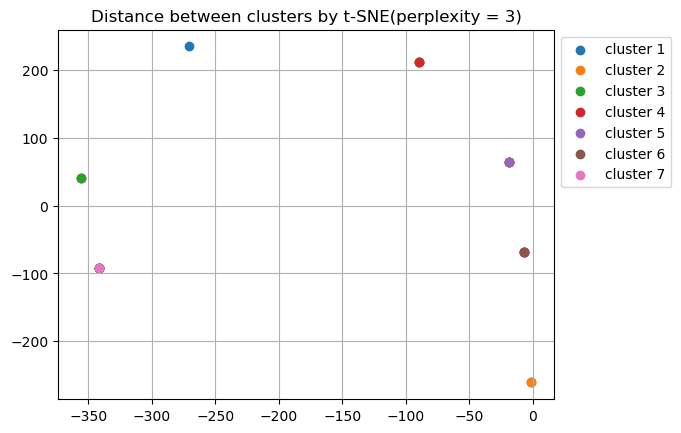

In [58]:
from sklearn.manifold import TSNE
w_embedded = TSNE(perplexity=3).fit_transform(nn1_weight_th)
print(w_embedded)
labels = list(range(1,8))
plt.figure()
for i in labels:
    plt.scatter(w_embedded[i - 1:,0], w_embedded[i - 1:,1], label = f"cluster {i}")
plt.title("Distance between clusters by t-SNE(perplexity = 3)")
plt.legend(loc='upper left',bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [27]:
# rois_list = pd.read_csv("../dataset/AAL/labels_and_networks_aal.csv", skiprows = 1).iloc[:, 1].to_list()
# sparse_res = "../log/model1/"
# k = 10
# res_dict = {}
# for i in range(5):
#     p = osp.join(sparse_res, f"model1_sparse{i + 1}.csv")
#     ws = pd.read_csv(p, header = 0)["abs_coef"].to_numpy()[2:,]
    # unsorted_max_indices = np.argpartition(-ws, 10)[:10]
    # y = ws[unsorted_max_indices]
    # indices = np.argsort(-y)
    # topk_indices = unsorted_max_indices[indices]
    # print(topk_indices)
    # print(nn1_weight_th[:,40])

(116,)
[1.]
(116,)
[1.]
(116,)
[1.]
(116,)
[1.]
(116,)
[1.]
